# How prepare data and the dataset.json for nnU-Net (pathology)

Make sure that you have ASAP installed on your system and added to you path or this notebook won't work. Download the appropriate version for your system at:
https://github.com/computationalpathologygroup/ASAP/releases

## Libraries

In [32]:
!pip3 install wholeslidedata SimpleITK
!pip3 install --upgrade --no-cache-dir gdown numpy

  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Programs\\anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [33]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel so the download libraries can take effect.

{'status': 'ok', 'restart': True}

In [1]:
import os
import sys
# If dealing with errors later on regarding ASAP and whole slide data and you are on windows, then this will probably be the solution.
# sys.path.append(r"C:\Program Files\ASAP 2.1\bin")
# os.add_dll_directory(r"C:\Program Files\ASAP 2.1\bin")
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.samplers.utils import one_hot_decoding
from matplotlib import pyplot as plt
from shapely.geometry import Point
import numpy as np
import pandas as pd
import SimpleITK as sitk
import yaml
from pathlib import Path
from glob import glob
import pandas as pd
import gdown
from tqdm.notebook import tqdm

## Download example data

In [2]:
_WSI_DOWNLOAD_LINK = 'https://drive.google.com/uc?id=1noRtbC5fxBlnO7YnvktjIDhFI61PdOSB'
_WSI_NAME = Path('TCGA-21-5784-01Z-00-DX1.tif')

_WSA_DOWNLOAD_LINK = 'https://drive.google.com/uc?id=1jkTp0IJHHpmLd1yDO1L3KRFJgm0STh0d'
_WSA_NAME = Path('TCGA-21-5784-01Z-00-DX1.xml')

def _download(output_folder, download_link, name):
    output_path = Path(output_folder) / name
    if not output_path.exists():
        gdown.download(download_link, str(output_path))
    return str(output_path)


def download_wsi(output_folder):
    return _download(output_folder, _WSI_DOWNLOAD_LINK, _WSI_NAME)


def download_wsa(output_folder):
    return _download(output_folder, _WSA_DOWNLOAD_LINK, _WSA_NAME)


def download(output_folder):
    return download_wsi(output_folder), download_wsa(output_folder)

download(".")

('TCGA-21-5784-01Z-00-DX1.tif', 'TCGA-21-5784-01Z-00-DX1.xml')

## Data import

In [3]:
yaml_data_source = "example_data.yaml"

In [4]:
with open (yaml_data_source, "w") as yaml_write:
    yaml_dict = dict(
        training=[
            dict(
                wsi=dict(path=str(_WSI_NAME.resolve())),
                wsa=dict(path=str(_WSA_NAME.resolve())))
        ], 
        validation=[
            dict(
                wsi=dict(path=str(_WSI_NAME.resolve())),
                wsa=dict(path=str(_WSA_NAME.resolve())))
        ]
    )
    yaml.dump(data=yaml_dict, stream=yaml_write)

In [5]:
data_split = dict()
with open(yaml_data_source, "r") as stream:
    try:
        data_split = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Train data

In [6]:
image_anno_train = [(image_annotation['wsi']['path'], image_annotation['wsa']['path'], Path(image_annotation['wsa']['path']).stem) for image_annotation in data_split['training']]
total_number_of_training_slides = len(image_anno_train)
print(total_number_of_training_slides)

1


### Initializing Whole Slide Data

In [7]:
labels={
  'tumor': 1,
  'lymphocytes': 2,
  'stroma': 3
}

In [8]:
minimal_patch_width = 1024 #
minimal_patch_height = 1024 # if this is larger than the input patch size of nnU-Net, then nnU-Net will randomly sample the right size patches

spacing = 0.5

In [9]:
yaml_dict = {
    'wholeslidedata': {
        'default': {
            'image_backend': 'asap',
            'seed': 123,
            'yaml_source': yaml_data_source,
        
            'label_map': labels,
            'label_sampler': {
                'attribute': 'OrderedLabelSampler'
            },
            'annotation_sampler': {
                'attribute': 'OrderedAnnotationSampler'            
            },
            'point_sampler': {
                'attribute': 'RandomPointSampler',
                'buffer': -minimal_patch_width//2
            }, 
            'batch_shape': {
                'batch_size': 1,
                'shape': [minimal_patch_width, minimal_patch_height, 3],
                'spacing': [spacing],
                'y_shape': [minimal_patch_width, minimal_patch_height, len(labels.keys())]
            },
            'sample_callbacks': [
                {
                    'module': 'wholeslidedata.samplers.callbacks',
                    'attribute': 'OneHotEncoding',
                    'labels': '${wholeslidedata:labels}'
                }            
            ]
        }
    }
}
user_config = "./user_config.yaml"
with open(user_config, "w") as fp:
    yaml.dump(yaml_dict, stream=fp, default_flow_style=False)

### Check images and annotations

In [10]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib import cm

color_values = ['white', 'firebrick', "green", "blue", "blue"]
cmap = ListedColormap(color_values)
bounds=list(range(len(color_values)))
norm = BoundaryNorm(bounds, cmap.N, clip=True)

In [11]:
label_names = ['other'] + list(labels.keys())
n_labels = len(label_names)
label_index = list(range(n_labels))
print(f"Label names {label_names}, label index {label_index}")

Label names ['other', 'tumor', 'lymphocytes', 'stroma'], label index [0, 1, 2, 3]


In [12]:
def add_zero_classes(classes, counts, len_labels):
    complete_counts = np.zeros(len_labels)
    for i in range(len(classes)):
        complete_counts[classes[i]] = counts[i]
    complete_counts.astype(int)
    return complete_counts

  0%|          | 0/10 [00:00<?, ?it/s]

[1024, 1024]


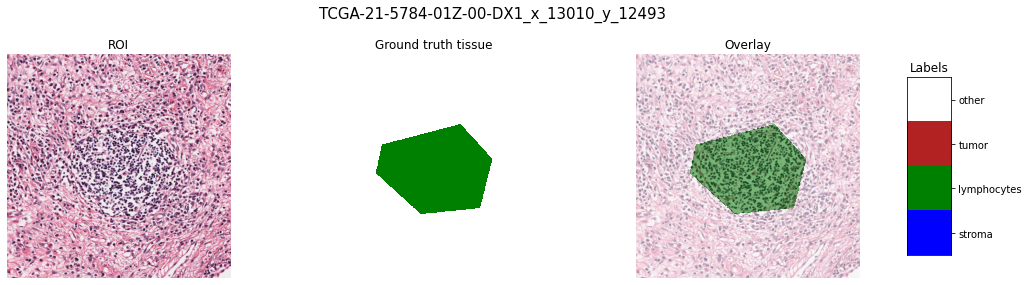

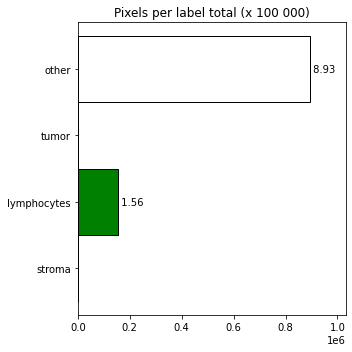

[1024, 1024]


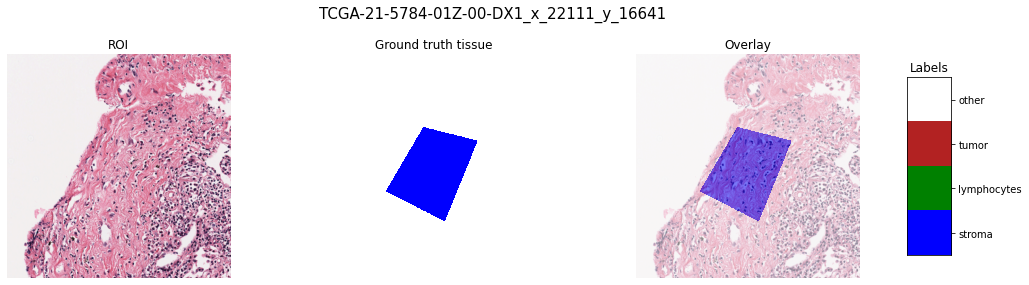

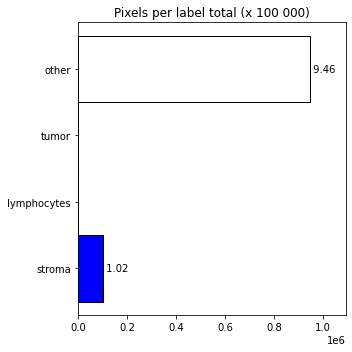

[1024, 1024]


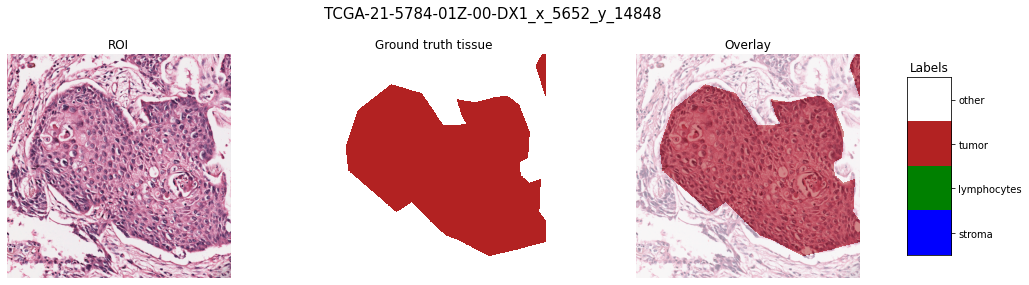

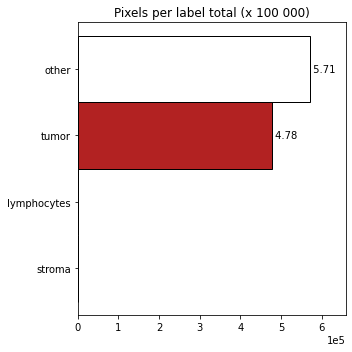

[1024, 1024]


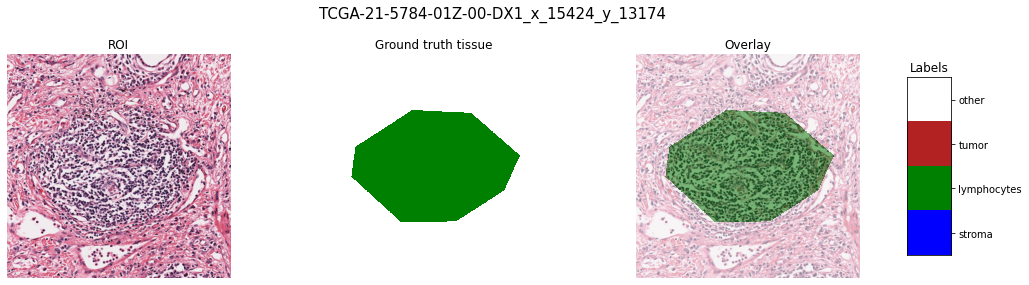

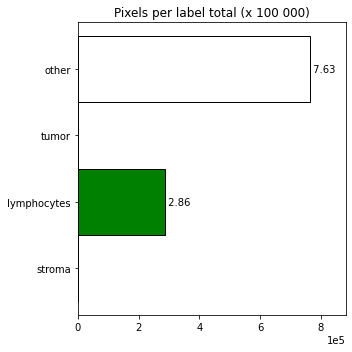

[1024, 1024]


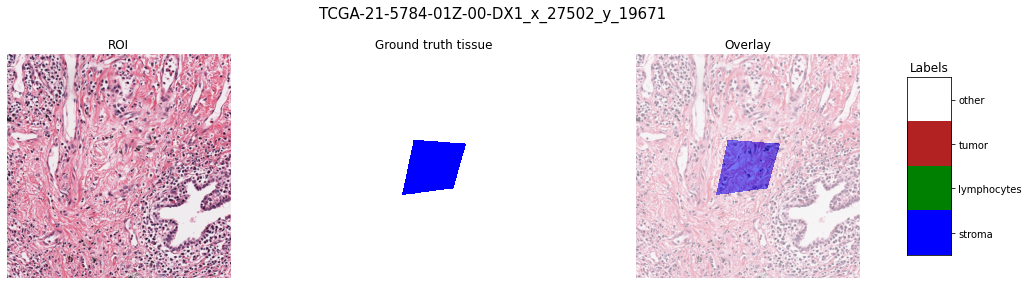

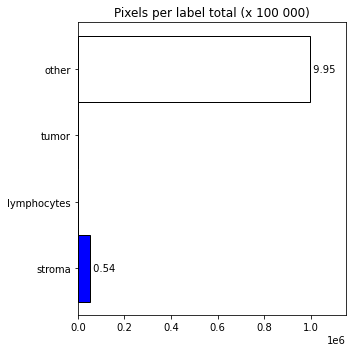

[1024, 1024]


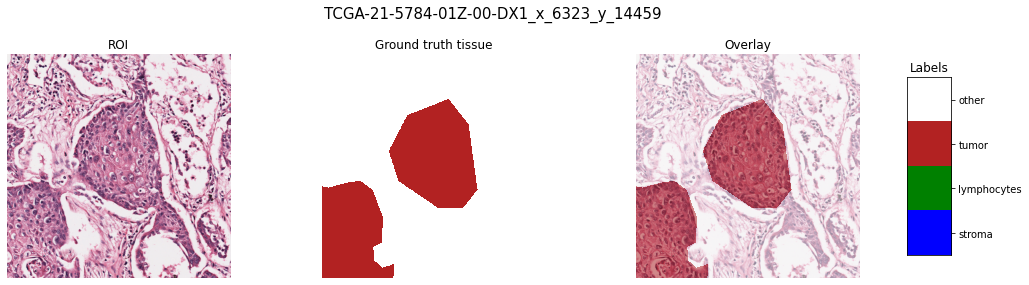

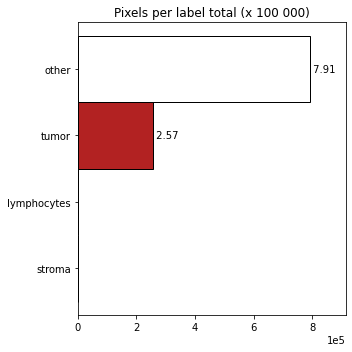

[1024, 1024]


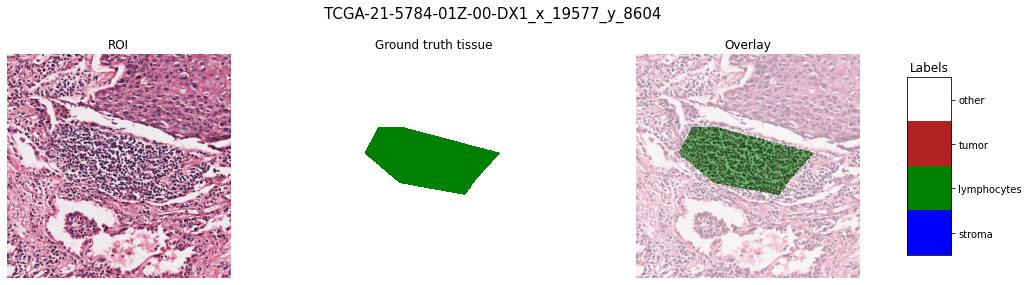

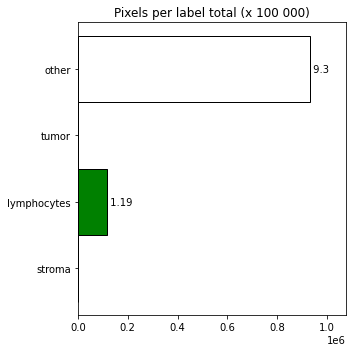

[1024, 1024]


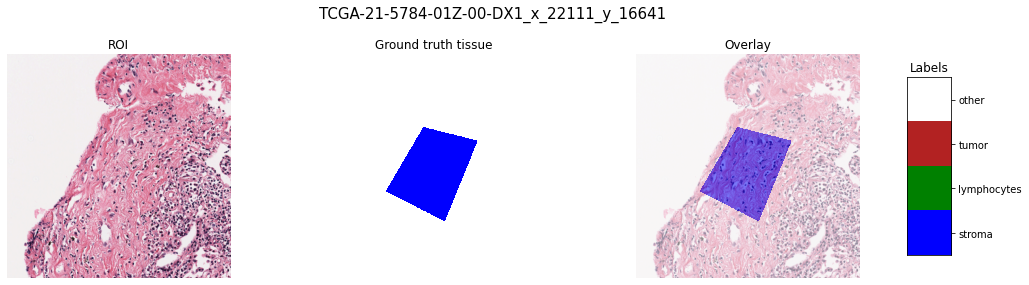

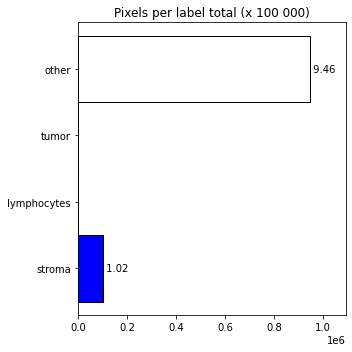

[1024, 1024]


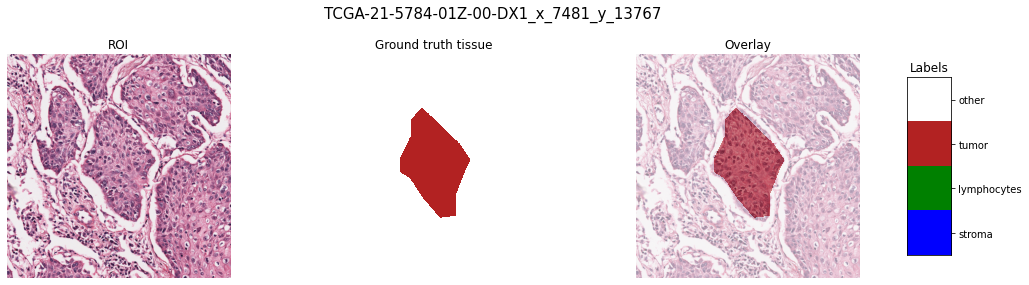

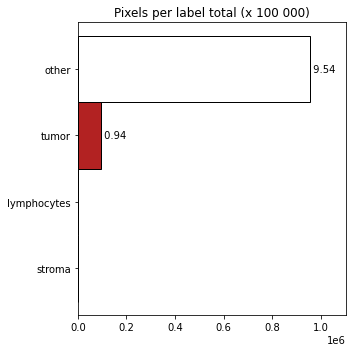

[1024, 1024]


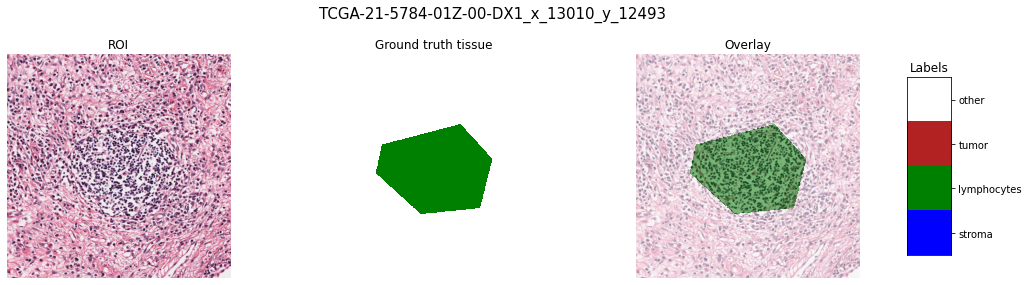

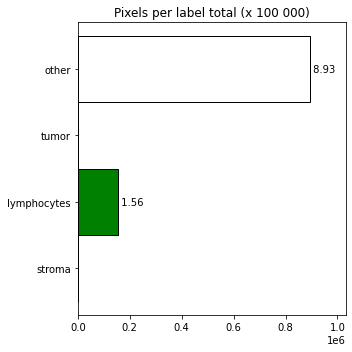

Total


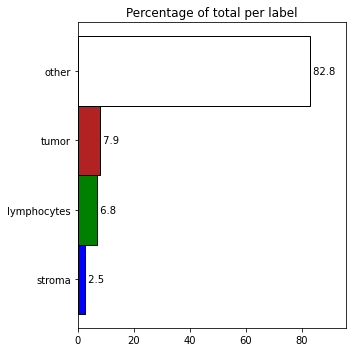

DONE


In [18]:
complete_counts_total = np.zeros(n_labels)
total_number_of_samples = 10

with create_batch_iterator(mode='training', user_config=user_config, cpus=4, number_of_batches=-1, return_info=True,
                           context='spawn' if os.name == 'nt' else 'fork') as training_iterator:
    for i in tqdm(range(total_number_of_samples)):
        x_batch, y_batch, info = next(training_iterator)
        s = info['sample_references'][0]['reference'].file_key
        x, y = [int(coord[-1]) for coord in info['sample_references'][0]['point'].xy]
        roi_patch = x_batch[0]
            
        print(list(reversed(roi_patch.shape[:2])))
        mask_patch = one_hot_decoding(y_batch[0], base=0).astype(int)

        ######### FIGURE 1 #########           
        ratio = [14, 2]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s + "_x_" + str(x) + "_y_" + str(y), fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, cmap=cmap, norm=norm, interpolation='nearest') 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.5) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in list(range(n_labels))], cmap=cmap, norm=norm, interpolation='nearest')
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()

        
        ######### FIGURE 2 #########   
        complete_counts = add_zero_classes(*np.unique(mask_patch, return_counts=True), len_labels=n_labels)
        
        fig, axs = plt.subplots(1,1, figsize=(5,5))
        bar_list = axs.barh(label_names, complete_counts, height=1) #, height=0.95, log=True)
        for i, bar in enumerate(bar_list):
            bar.set_color(cmap(label_index[i]))
            bar.set_edgecolor("black")
        axs.invert_yaxis()
        axs.set_title("Pixels per label total (x 100 000)")
        for i in range(n_labels):
            plt.text(complete_counts[i], i, s=" " + str(round(complete_counts[i]/100000, 2)) if complete_counts[i] !=0.0 else "", 
                     ha="left", va="center")
        axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.tight_layout()
        plt.show()
        
        complete_counts_total += complete_counts
######### FIGURE 3 #########  
print("Total")
sum_total = sum(complete_counts_total)
percentages_total = [round((count/sum_total)*100,1) for count in complete_counts_total]
fig, axs = plt.subplots(1,1, figsize=(5,5))
bar_list = axs.barh(label_names, percentages_total, height=1) #, height=0.95, log=True)
for i, bar in enumerate(bar_list):
    bar.set_color(cmap(label_index[i]))
    bar.set_edgecolor("black")
axs.invert_yaxis()
axs.set_title("Percentage of total per label")
for i in range(n_labels):
    plt.text(percentages_total[i], i, s=" " + str(percentages_total[i]), 
             ha="left", va="center")
axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
plt.tight_layout()
plt.show()
print("DONE")

## Transform to NIFTI function

In [19]:
def convert_2d_image_to_nifti(input_filename: str, output_filename_truncated: str, spacing=(999, 1, 1),
                              transform=None, is_seg: bool = False) -> None:
    """
    Reads an image (must be a format that it recognized by skimage.io.imread) and converts it into a series of niftis.
    The image can have an arbitrary number of input channels which will be exported separately (_0000.nii.gz,
    _0001.nii.gz, etc for images and only .nii.gz for seg).
    Spacing can be ignored most of the time. 
    Datasets converted with this utility can only be used with the 2d U-Net configuration of nnU-Net
    If Transform is not None it will be applied to the image after loading.
    Segmentations will be converted to np.uint32!
    :param is_seg:
    :param transform:
    :param input_filename:
    :param output_filename_truncated: do not use a file ending for this one! Example: output_name='./converted/image1'. This
    function will add the suffix (_0000) and file ending (.nii.gz) for you.
    :param spacing:
    :return:
    """
    # img = io.imread(input_filename)
    img = input_filename

    if transform is not None:
        img = transform(img)

    if len(img.shape) == 2:  # 2d image with no color channels
        img = img[None, None]  # add dimensions
    else:
        assert len(img.shape) == 3, "image should be 3d with color channel last but has shape %s" % str(img.shape)
        # we assume that the color channel is the last dimension. Transpose it to be in first
        img = img.transpose((2, 0, 1))
        # add third dimension
        img = img[:, None]

    # image is now (c, x, x, z) where x=1 since it's 2d
    if is_seg:
        assert img.shape[0] == 1, 'segmentations can only have one color channel, not sure what happened here'

    for j, i in enumerate(img):
        if is_seg:
            i = i.astype(np.uint32)

        itk_img = sitk.GetImageFromArray(i)
        itk_img.SetSpacing(list(spacing)[::-1])
        if not is_seg:
            sitk.WriteImage(itk_img, output_filename_truncated + "_%04.0d.nii.gz" % j)
        else:
            sitk.WriteImage(itk_img, output_filename_truncated + ".nii.gz")

## Create nnUNet train dataset

Change Task name here for a new project:

In [20]:
task_name = "Task501_segmentation"
nnUNet_base = r"./nnUNet_raw_data_base"
nnUNet_data_root = os.path.join(nnUNet_base, "nnUNet_raw_data")
task_root = os.path.join(nnUNet_data_root, task_name)
image_folder = os.path.join(task_root, "imagesTr")
label_folder = os.path.join(task_root, "labelsTr")

### Makedirs

In [21]:
os.makedirs(image_folder)
os.makedirs(label_folder)

### Make nifti files

In [23]:
total_number_of_samples = 10

with create_batch_iterator(mode='training', user_config=user_config, cpus=4, number_of_batches=-1, return_info=True,
                           context='spawn' if os.name == 'nt' else 'fork') as training_iterator:
    for i in tqdm(range(total_number_of_samples)):
        x_batch, y_batch, info = next(training_iterator)
        s = info['sample_references'][0]['reference'].file_key
        x, y = [int(coord[-1]) for coord in info['sample_references'][0]['point'].xy]
        roi_patch = x_batch[0]
        mask_patch = one_hot_decoding(y_batch[0], base=0).astype(int)

        
        # MAKE OUTPUT
        output_filename = s+"_x_" + str(x) + "_y_" + str(y)
        convert_2d_image_to_nifti(roi_patch, os.path.join(image_folder, output_filename))
        convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)
print("DONE")

  0%|          | 0/10 [00:00<?, ?it/s]

DONE


## Create dataset json

### Function

In [24]:
labels.update({'other': 0})

In [25]:
import os
import json
import re
import numpy as np

def GenerateJson(dataset_path):
    dataset = {}
    dataset['name'] = 'TCGA-placeholder-name'
    dataset['description'] = 'TCGA-placeholder-description'
    dataset['reference'] = 'Radboud University Medical Center '
    dataset['licence'] = 'XXXX'
    dataset['relase'] = 'X.XX'
    dataset['tensorImageSize'] = '2D'
    dataset['modality'] = {
        "0": "zeroToOne", 
        "1": "zeroToOne", 
        "2": "zeroToOne" 
    }
    
    dataset['labels'] = labels
    dataset['training'] = []
    dataset['test'] = []
    images_path = os.path.join(dataset_path, 'imagesTr')

    filelist = os.listdir(images_path)
    filelist = [re.sub(r'_000\d', '', f) for f in filelist]
    filelist = np.unique(filelist)

    for f in filelist:
        json_imagetr = './' + 'imagesTr/' + f
        json_mask = './' + 'labelsTr/' + f

        dataset['training'].append({
            'image': json_imagetr,
            'label': json_mask
        })


    dataset['numTraining'] = len(filelist)
    json_path = os.path.join(dataset_path, 'dataset.json')
    with open(json_path, 'w') as outfile:
        json.dump(dataset, outfile, indent=4)

In [26]:
dataset_path = task_root

### Make dataset json

In [27]:
print(dataset_path)
GenerateJson(dataset_path)

./nnUNet_raw_data_base\nnUNet_raw_data\Task501_segmentation


## Test data

### Check images and annotations

In [28]:
image_anno_test = [(image_annotation['wsi']['path'], image_annotation['wsa']['path'], Path(image_annotation['wsa']['path']).stem) for image_annotation in data_split['validation']]
total_number_of_test_slides = len(image_anno_test)
print(total_number_of_test_slides)

1


  0%|          | 0/10 [00:00<?, ?it/s]

[1024, 1024]


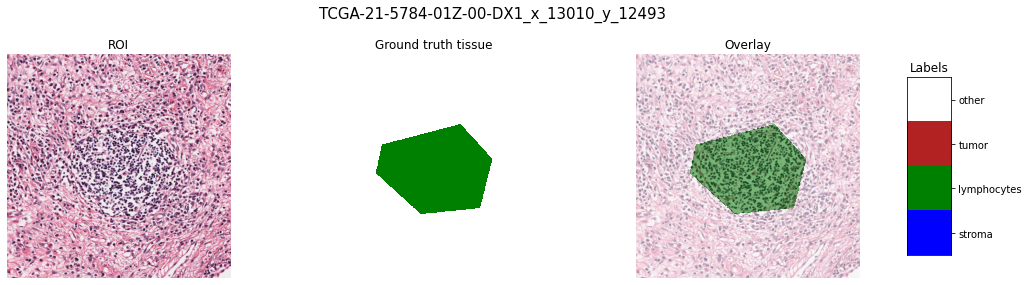

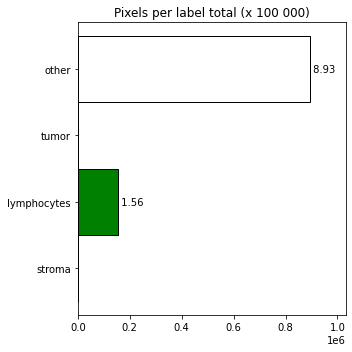

[1024, 1024]


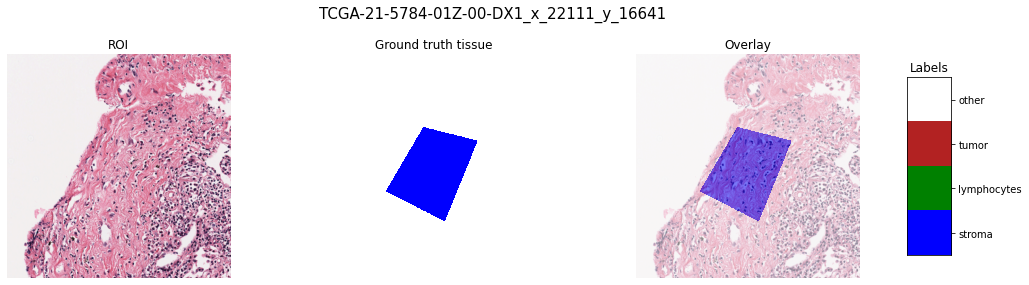

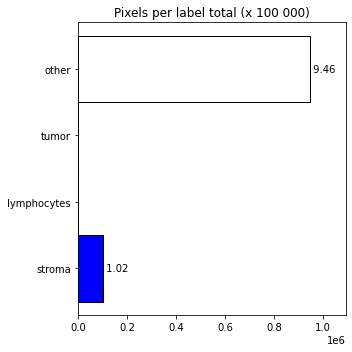

[1024, 1024]


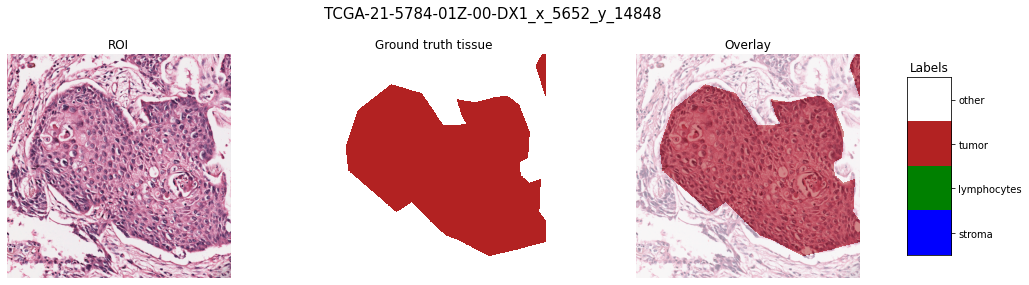

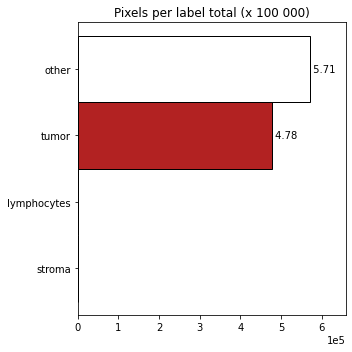

[1024, 1024]


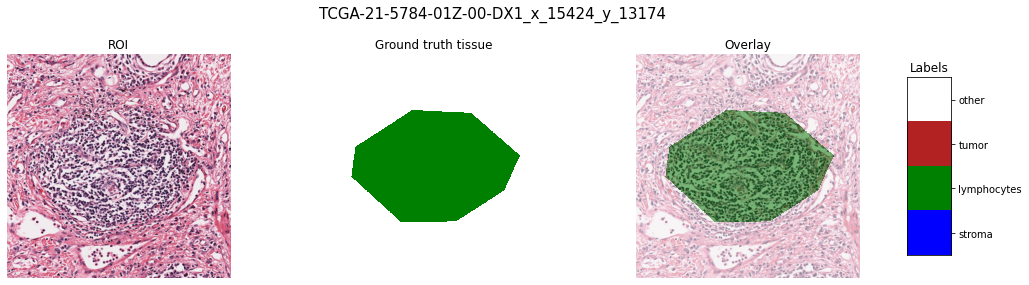

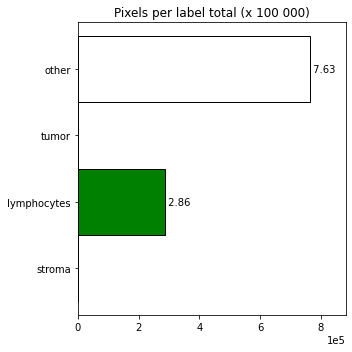

[1024, 1024]


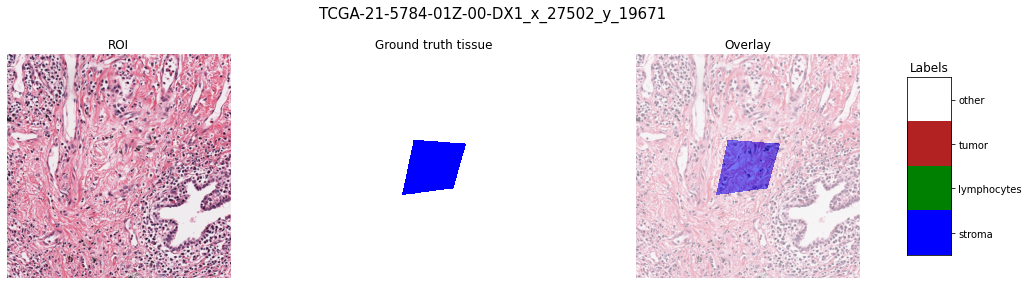

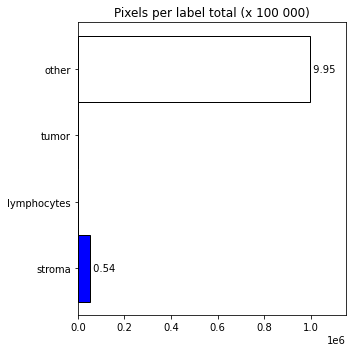

[1024, 1024]


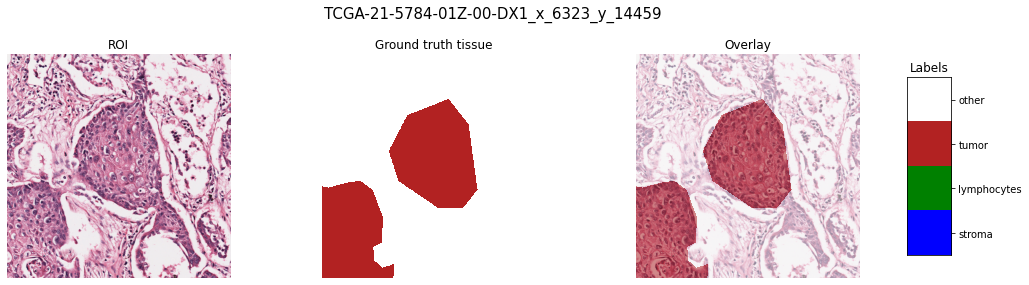

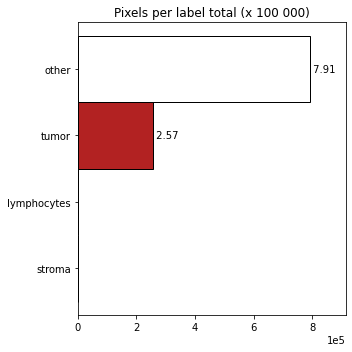

[1024, 1024]


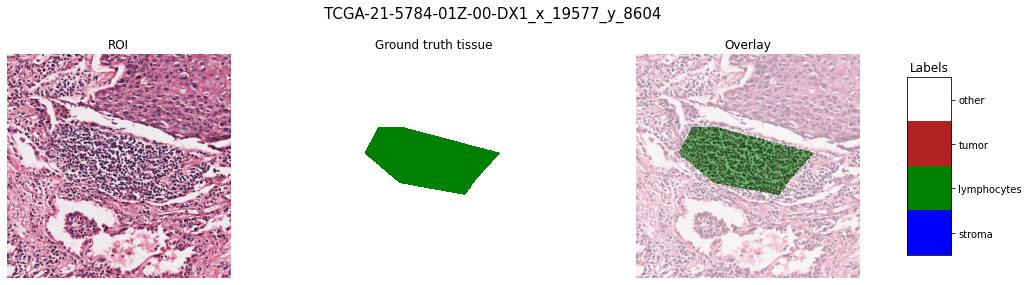

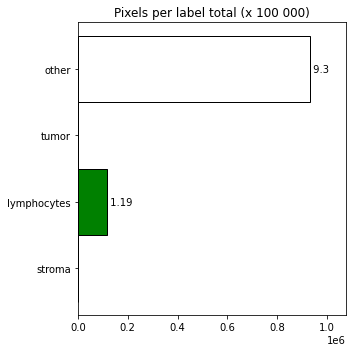

[1024, 1024]


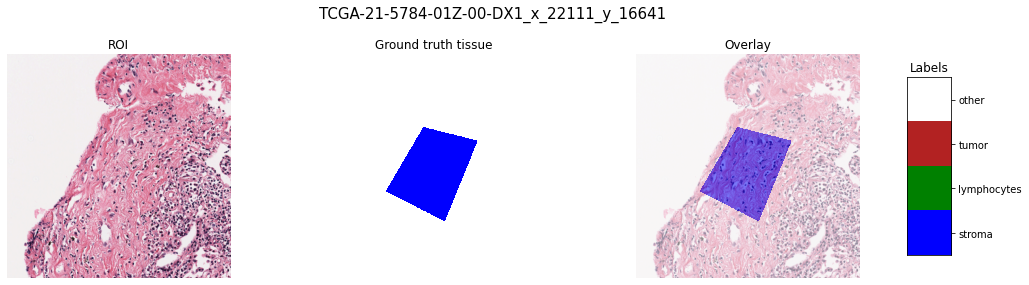

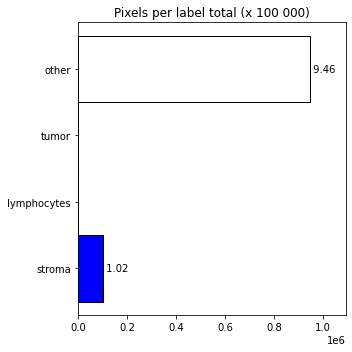

[1024, 1024]


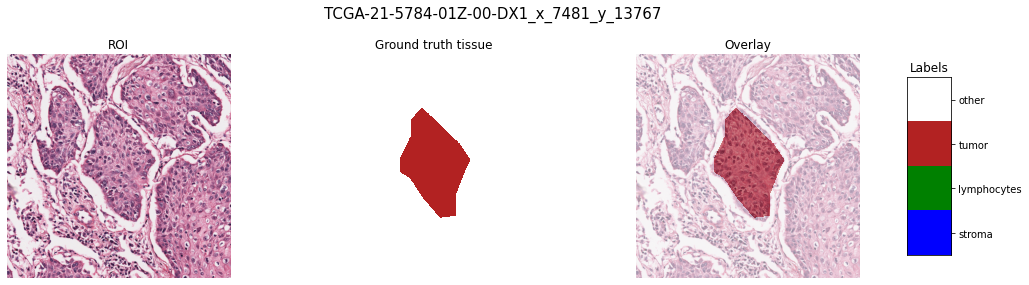

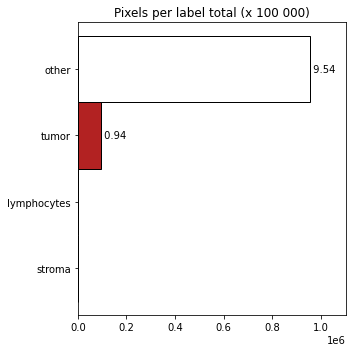

[1024, 1024]


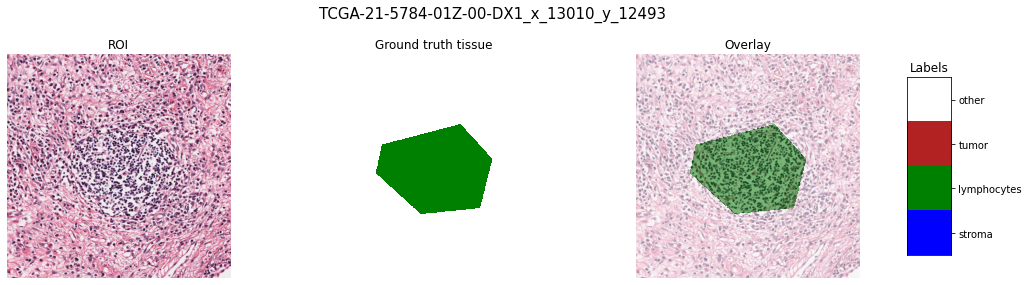

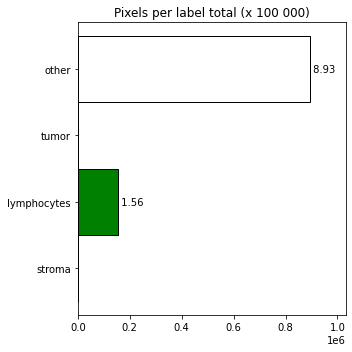

Total


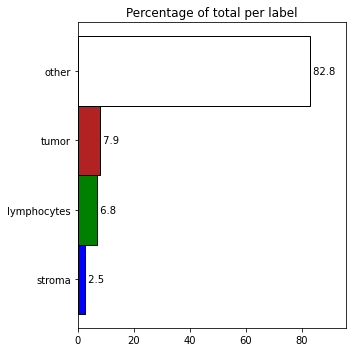

DONE


In [30]:
complete_counts_total = np.zeros(n_labels)
total_number_of_samples = 10

with create_batch_iterator(mode='validation', user_config=user_config, cpus=4, number_of_batches=-1, return_info=True,
                           context='spawn' if os.name == 'nt' else 'fork') as training_iterator:
    for i in tqdm(range(total_number_of_samples)):
        x_batch, y_batch, info = next(training_iterator)
        x, y = [int(coord[-1]) for coord in info['sample_references'][0]['point'].xy]
        roi_patch = x_batch[0]
            
        print(list(reversed(roi_patch.shape[:2])))
        mask_patch = one_hot_decoding(y_batch[0], base=0).astype(int)

        ######### FIGURE 1 #########           
        ratio = [14, 2]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s+"_x_" + str(x) + "_y_" + str(y), fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, cmap=cmap, norm=norm, interpolation='nearest') 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.5) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in list(range(n_labels))], cmap=cmap, norm=norm, interpolation='nearest')
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()

        
        ######### FIGURE 2 #########   
        complete_counts = add_zero_classes(*np.unique(mask_patch, return_counts=True), len_labels=n_labels)
        
        fig, axs = plt.subplots(1,1, figsize=(5,5))
        bar_list = axs.barh(label_names, complete_counts, height=1) #, height=0.95, log=True)
        for i, bar in enumerate(bar_list):
            bar.set_color(cmap(label_index[i]))
            bar.set_edgecolor("black")
        axs.invert_yaxis()
        axs.set_title("Pixels per label total (x 100 000)")
        for i in range(n_labels):
            plt.text(complete_counts[i], i, s=" " + str(round(complete_counts[i]/100000, 2)) if complete_counts[i] !=0.0 else "", 
                     ha="left", va="center")
        axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.tight_layout()
        plt.show()
        
        complete_counts_total += complete_counts
######### FIGURE 3 #########  
print("Total")
sum_total = sum(complete_counts_total)
percentages_total = [round((count/sum_total)*100,1) for count in complete_counts_total]
fig, axs = plt.subplots(1,1, figsize=(5,5))
bar_list = axs.barh(label_names, percentages_total, height=1) #, height=0.95, log=True)
for i, bar in enumerate(bar_list):
    bar.set_color(cmap(label_index[i]))
    bar.set_edgecolor("black")
axs.invert_yaxis()
axs.set_title("Percentage of total per label")
for i in range(n_labels):
    plt.text(percentages_total[i], i, s=" " + str(percentages_total[i]), 
             ha="left", va="center")
axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
plt.tight_layout()
plt.show()
print("DONE")

## Create nnUNet test dataset

In [31]:
print("TASK:\t\t", task_name)
# print("nnUNet ROOT:\t\t", nnUNet_base_linux)
print("DATA ROOT:\t", nnUNet_data_root)
print("TASK ROOT\t", task_root)
test_image_folder = os.path.join(task_root, "imagesTs")
print("TEST IMAGES\t", test_image_folder)
test_label_folder = os.path.join(task_root, "labelsTs")
print("TEST LABELS\t", test_label_folder)

TASK:		 Task501_segmentation
DATA ROOT:	 ./nnUNet_raw_data_base\nnUNet_raw_data
TASK ROOT	 ./nnUNet_raw_data_base\nnUNet_raw_data\Task501_segmentation
TEST IMAGES	 ./nnUNet_raw_data_base\nnUNet_raw_data\Task501_segmentation\imagesTs
TEST LABELS	 ./nnUNet_raw_data_base\nnUNet_raw_data\Task501_segmentation\labelsTs


### Makedirs

In [32]:
os.makedirs(test_image_folder)
os.makedirs(test_label_folder)

### Make nifti files

In [33]:
total_number_of_samples = 10

with create_batch_iterator(mode='training', user_config=user_config, cpus=4, number_of_batches=-1, return_info=True,
                           context='spawn' if os.name == 'nt' else 'fork') as training_iterator:
    for i in tqdm(range(total_number_of_samples)):
        x_batch, y_batch, info = next(training_iterator)
        
        s = info['sample_references'][0]['reference'].file_key
        x, y = [int(coord[-1]) for coord in info['sample_references'][0]['point'].xy]
        roi_patch = x_batch[0]
        mask_patch = one_hot_decoding(y_batch[0], base=0).astype(int)

        
        # MAKE OUTPUT
        output_filename = s+"_x_" + str(x) + "_y_" + str(y)
        convert_2d_image_to_nifti(roi_patch, os.path.join(test_image_folder, output_filename))
        convert_2d_image_to_nifti(mask_patch, os.path.join(test_label_folder, output_filename), is_seg=True)
print("DONE")

  0%|          | 0/10 [00:00<?, ?it/s]

DONE


### Update dataset.json

In [34]:
import json, re
def update_dataset_with_test_images(dataset_path):
    with open(os.path.join(dataset_path, "dataset.json"), "r") as fp:
        dataset = json.load(fp=fp)
        
    images_path = os.path.join(dataset_path, 'imagesTs')

    filelist = os.listdir(images_path)
    filelist = [re.sub(r'_000\d', '', f) for f in filelist]
    filelist = np.unique(filelist)

    for f in filelist:
        json_imagetr = './' + 'imagesTs/' + f

        dataset['test'].append(json_imagetr)


    dataset['numTest'] = len(filelist)
    json_path = os.path.join(dataset_path, 'dataset.json')
    with open(json_path, 'w') as outfile:
        json.dump(dataset, outfile, indent=4)

In [35]:
update_dataset_with_test_images(task_root)